In [1]:
##################################################################################################################################
#                                                                                                                                #
#                             An Explainable AI Framework for Satellite Network Anomaly Detection                                #
#                                                                                                                                #
#                                                                                                                                #
#                                        *******   Signal Loss Artifact   *******                                                #
#                                                                                                                                #
#                                                                                                                                #
#                                                    University of Hull                                                          #
#                                                MSc Artificial Intelligence                                                     #
#                                                                                                                                #
#                                                      Amadiz Sabino                                                             #
#                                                                                                                                #
##################################################################################################################################

In [2]:
# ============================================================
# Step 1 — Mounting the Google Drive
# Set the DATA_DIR dir
# ============================================================

from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

DATA_DIR = "/content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses"
print("DATA_DIR:", DATA_DIR)
!ls "$DATA_DIR"

Mounted at /content/drive
DATA_DIR: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses
 3_3_SES_Jamming_Interference.ipynb
' 3_3_SES_Prototype_BeamHandover.ipynb'
 3_3_SES_Prototype_SignalLoss.ipynb
 3_3_SES_Prototype_SLA_Proxy.ipynb
 3_3_SES_Space_Weather.ipynb
 Archive
 artifacts_handover
 artifacts_powerfault
 artifacts_signal_loss
 artifacts_sla
 AttitudePIDs.csv
 CIEL2_ManeuverEvents_R1.csv
 gfz_kp_ap_2012-01-01_2020-02-27.csv
 gfz_kp_ap_2023.csv
 LabelManeuverEvents.m
 phase3_ESA-Mission1
 Remove__3_3_SES_Space_Weather_v2.ipynb
 Removed___3_3_SES_Prototype_PowerLoss.ipynb
 ses_clean_10s.parquet
 ses_comm_anomalies.csv
 ses_comm_features.csv
 SESGroundData_Oct-Nov_AS1.xlsx
 ses_maneuver_features.csv
 ses_spaceweather_dataset.csv
 space_weather_gfz_kp_ap_2023_v1.csv
 ThrusterTemperaturePIDs.csv


In [3]:
import os

# Check if the drive is mounted by listing the contents of the drive directory
drive_mounted = os.path.exists('/content/drive')

if drive_mounted:
  print("Google Drive is mounted successfully.")
  # Optionally, list the contents of the drive to confirm access
  print("Contents of /content/drive:")
  print(os.listdir('/content/drive'))
else:
  print("Google Drive is not mounted.")

Google Drive is mounted successfully.
Contents of /content/drive:
['MyDrive', 'Othercomputers', '.shortcut-targets-by-id', '.Trash-0', '.Encrypted']


In [4]:
# ============================================================
# Step 2 — Install and import libraries
# ============================================================

!pip -q install pandas numpy scikit-learn xgboost shap

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
import shap


plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


In [10]:
# ============================================================
# Step 3A — Load SES dataset (Excel -> time-indexed DataFrame)
# Load Analyse the data
# ============================================================

# Raw Excel file (SES dataset)
path = os.path.join(DATA_DIR, "SESGroundData_Oct-Nov_AS1.xlsx")
df = pd.read_excel(path, sheet_name=0)

# Convert '_time' column to datetime and set as index
df["_time"] = pd.to_datetime(df["_time"])
df = df.set_index("_time")

# Step 3A — Deduplicate timestamps, basic cleanup
df = df[~df.index.duplicated(keep="last")].sort_index()
print("Step3A-4G: After dedup time span:", df.index.min(), "→", df.index.max())
print("Rows:", len(df))

# Coerce all numeric-like columns to numeric
num_df = df.copy()
for c in num_df.columns:
    if num_df[c].dtype == "object":
        num_df[c] = pd.to_numeric(num_df[c], errors="coerce")

# Identify non-numeric columns
non_numeric = [c for c in num_df.columns if not pd.api.types.is_numeric_dtype(num_df[c])]
print("Non-numeric columns:", non_numeric)


Step3A-4G: After dedup time span: 2021-10-18 07:25:10+00:00 → 2021-11-30 23:59:50+00:00
Rows: 377489
Non-numeric columns: []


In [11]:
# ============================================================
# Step 3B — Drop near-constant columns (no and sparse columns
# ============================================================

def is_near_constant(series, tol=1e-9):
    s = series.dropna()
    return (s.max() - s.min()) <= tol

near_const = [
    c for c in num_df.columns
    if pd.api.types.is_numeric_dtype(num_df[c]) and is_near_constant(num_df[c])
]
print("Near-constant cols:", near_const)

# Drop columns with >30% missing
missing_pct = num_df.isna().mean().sort_values(ascending=False)
print("Top missingness:\n", missing_pct.head(10))

sparse_cols = missing_pct[missing_pct > 0.30].index.tolist()
print("Dropped sparse cols:", sparse_cols)

num_df = num_df.drop(columns=sparse_cols)


Near-constant cols: []
Top missingness:
 Spacecraft       1.000000
ANT_4_ACU        0.972516
MODEM__3_OUT     0.914045
MODEM__3_IN      0.910326
MODEM__37_IN     0.886905
MODEM__37_OUT    0.886601
MODEM__34_IN     0.881811
MODEM__34_OUT    0.880714
MODEM__33_OUT    0.878102
MODEM__33_IN     0.866396
dtype: float64
Dropped sparse cols: ['Spacecraft', 'ANT_4_ACU', 'MODEM__3_OUT', 'MODEM__3_IN', 'MODEM__37_IN', 'MODEM__37_OUT', 'MODEM__34_IN', 'MODEM__34_OUT', 'MODEM__33_OUT', 'MODEM__33_IN', 'MODEM__10_IN', 'MODEM__10_OUT', 'ANT_3_ACU', 'MODEM__22_OUT', 'MODEM__22_IN', 'ANT_2_ACU', 'ANT_1_ACU']


In [12]:
# ============================================================
# Step 3C — Resample to 10-second cadence + light fill + clipping
# ============================================================

# There is already a 10s cadence; resample ensures regular index
res = num_df.resample("10s").last()

# Forward-fill short gaps (up to 20s = 2 steps)
res = res.ffill(limit=2)

# Clip extreme outliers at 0.5% and 99.5% per column
q_low = res.quantile(0.005)
q_high = res.quantile(0.995)
res = res.clip(lower=q_low, upper=q_high, axis=1)

print("Resampled shape:", res.shape)
print("Resampled time span:", res.index.min(), "→", res.index.max())


Resampled shape: (377489, 28)
Resampled time span: 2021-10-18 07:25:10+00:00 → 2021-11-30 23:59:50+00:00


In [13]:
# ============================================================
# Step 3D — Maneuver mask (from CIEL2_ManeuverEvents_R1.csv)
# This ended up all zeros, but it is keeping the logic for completeness.
# ============================================================

man_path = os.path.join(DATA_DIR, "CIEL2_ManeuverEvents_R1.csv")
maneuver_mask = pd.Series(False, index=res.index)

if os.path.exists(man_path):
    man = pd.read_csv(man_path, header=None, names=["StartTime", "EndTime", "EventType"])
    tz = res.index.tz

    man["StartTime"] = pd.to_datetime(man["StartTime"], errors="coerce")
    man["EndTime"]   = pd.to_datetime(man["EndTime"], errors="coerce")

    if tz is not None:
        man["StartTime"] = man["StartTime"].dt.tz_localize(tz, nonexistent="shift_forward", ambiguous="NaT")
        man["EndTime"]   = man["EndTime"].dt.tz_localize(tz, nonexistent="shift_forward", ambiguous="NaT")

    idx = res.index
    for s, e in zip(man["StartTime"], man["EndTime"]):
        if pd.isna(s) or pd.isna(e):
            continue
        s_clip = max(s, idx[0])
        e_clip = min(e, idx[-1])
        if s_clip <= e_clip:
            maneuver_mask.loc[s_clip:e_clip] = True

    # Pad ±2 minutes
    pad = pd.Timedelta(minutes=2)
    steps = int(pad.total_seconds() / 10)
    padded = maneuver_mask.copy()
    padded |= maneuver_mask.shift(+steps, fill_value=False)
    padded |= maneuver_mask.shift(-steps, fill_value=False)
    maneuver_mask = maneuver_mask | padded

print("Maneuver fraction (all):", maneuver_mask.mean().round(3))

# Attach as a context column
res = res.assign(in_maneuver=maneuver_mask.astype(int))


Maneuver fraction (all): 0.0


In [14]:
# ============================================================
# Step 4 — Robust scaling on TRAIN only, then snapshot
# ============================================================

split_train = int(len(res) * 0.6)  # 60% of rows
scaler = RobustScaler()

scaled = res.copy()
scaled.iloc[:split_train] = scaler.fit_transform(res.iloc[:split_train])
scaled.iloc[split_train:] = scaler.transform(res.iloc[split_train:])

work = scaled  # final numeric+context working frame

print("Step4: Prepared frame (work) shape:", work.shape)

# Save the cleaned snapshot
clean_path = os.path.join(DATA_DIR, "ses_clean_10s.parquet")
work.to_parquet(clean_path)
print("Saved cleaned snapshot:", clean_path)

# Train exclusion mask (avoid maneuvers in training)
train_exclude_mask = maneuver_mask.iloc[:split_train]
print("Maneuver fraction (train):", train_exclude_mask.mean().round(3))


Step4H-4I: Prepared frame (work) shape: (377489, 29)
Saved cleaned snapshot: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/ses_clean_10s.parquet
Maneuver fraction (train): 0.0


In [15]:
# ============================================================
# Step 5 — Automatic selection of MODEM channels for signal-loss proxy
# ============================================================

ALL_COLS = [c for c in work.columns if isinstance(c, str)]

# Find all MODEM_*_IN or MODEM_*_OUT
pattern_candidates = []
for c in ALL_COLS:
    cl = c.lower()
    if "modem" in cl and (cl.endswith("_in") or cl.endswith("_out")):
        pattern_candidates.append(c)

print(f"Step5: Found {len(pattern_candidates)} MODEM IN/OUT candidates:")
print(pattern_candidates[:30])

# Also rank high-variance numeric columns (fallback)
NUMERIC_COLS = [c for c in ALL_COLS if pd.api.types.is_numeric_dtype(work[c])]
NUMERIC_COLS_NO_FLAG = [c for c in NUMERIC_COLS if c != "in_maneuver"]
var_rank = work[NUMERIC_COLS_NO_FLAG].var().sort_values(ascending=False)
fallback_candidates = var_rank.head(20).index.tolist()
print("\nTop-variance fallback candidates:")
print(fallback_candidates)

# Final selection: use MODEM channels (prefer)
if len(pattern_candidates) >= 6:
    sel_cols = pattern_candidates[:6]
else:
    sel_cols = fallback_candidates[:6]

keep_context = ["in_maneuver"] if "in_maneuver" in work.columns else []
res_sig = work[sel_cols + keep_context].copy()

print("Selected channels:", sel_cols)
print("Context kept:", keep_context)
print("res_sig shape:", res_sig.shape)


Step5: Found 28 MODEM IN/OUT candidates:
['MODEM__11_IN', 'MODEM__11_OUT', 'MODEM__14_IN', 'MODEM__14_OUT', 'MODEM__16_IN', 'MODEM__16_OUT', 'MODEM__23_IN', 'MODEM__23_OUT', 'MODEM__24_IN', 'MODEM__24_OUT', 'MODEM__25_IN', 'MODEM__25_OUT', 'MODEM__26_IN', 'MODEM__26_OUT', 'MODEM__27_IN', 'MODEM__27_OUT', 'MODEM__28_IN', 'MODEM__28_OUT', 'MODEM__32_IN', 'MODEM__32_OUT', 'MODEM__4_IN', 'MODEM__4_OUT', 'MODEM__5_IN', 'MODEM__5_OUT', 'MODEM__8_IN', 'MODEM__8_OUT', 'MODEM__9_IN', 'MODEM__9_OUT']

Top-variance fallback candidates:
['MODEM__23_OUT', 'MODEM__9_IN', 'MODEM__5_IN', 'MODEM__4_IN', 'MODEM__11_OUT', 'MODEM__14_IN', 'MODEM__27_OUT', 'MODEM__11_IN', 'MODEM__25_IN', 'MODEM__8_OUT', 'MODEM__28_IN', 'MODEM__28_OUT', 'MODEM__16_OUT', 'MODEM__26_OUT', 'MODEM__14_OUT', 'MODEM__27_IN', 'MODEM__5_OUT', 'MODEM__26_IN', 'MODEM__32_IN', 'MODEM__25_OUT']
Selected channels: ['MODEM__11_IN', 'MODEM__11_OUT', 'MODEM__14_IN', 'MODEM__14_OUT', 'MODEM__16_IN', 'MODEM__16_OUT']
Context kept: ['in_maneu

In [16]:
# ============================================================
# Step 6 — Weak supervision: signal-loss labels
# Drop below rolling 10th-percentile baseline for >=60s
# ============================================================

label_cols = [c for c in res_sig.columns if c != "in_maneuver"]

win_baseline = "2h"   # 2-hour rolling window
persist_s    = 60     # must stay below baseline for 60s
drop_q       = 0.10   # 10th percentile baseline

# Rolling baselines per channel
baseline = res_sig[label_cols].rolling(win_baseline, min_periods=6).quantile(drop_q)

# Below-baseline mask
below = (res_sig[label_cols] < baseline)

# Persist for >= 60s (6 samples at 10s cadence)
steps = persist_s // 10
persist_mask = below.rolling(steps, min_periods=steps).sum() == steps

# Signal loss label = any selected channel degraded
signal_loss = persist_mask.any(axis=1).astype(int)
signal_loss.name = "signal_loss"

print("Step6: Label prevalence (fraction of 1s):", signal_loss.mean().round(4))


Step6: Label prevalence (fraction of 1s): 0.2984


In [17]:

# ============================================================
# Step 7 — Feature engineering: rolling stats, diffs, slopes
# ============================================================

def make_features(X):
    """
    Build local temporal features:
      - 5-minute rolling mean & std
      - one-step difference
      - 5-sample rolling slope (~50s)
    """
    mean5  = X.rolling("5min").mean().add_suffix("_mean5m")
    std5   = X.rolling("5min").std().add_suffix("_std5m")
    diff1  = X.diff(1).add_suffix("_d1")
    slope5 = X.diff().rolling(5).mean().add_suffix("_slope5")

    feats = pd.concat([mean5, std5, diff1, slope5], axis=1)
    return feats

feature_cols = [c for c in res_sig.columns if c != "in_maneuver"]
X = make_features(res_sig[feature_cols])

# Add in_maneuver flag as a feature (optional, small effect)
if "in_maneuver" in res_sig.columns:
    X = X.join(res_sig["in_maneuver"])

# Drop warm-up periods with incomplete windows
X = X.dropna()

# Align labels to feature index
y = signal_loss.reindex(X.index).fillna(0).astype(int)

print("Step7: Feature matrix shape:", X.shape)
print("Target prevalence (on feature index):", y.mean().round(4))


Step7: Feature matrix shape: (355388, 25)
Target prevalence (on feature index): 0.3043


In [18]:

# ============================================================
# Step 8A — Time-based split (60/20/20)
# ============================================================

n = len(X)
train_end = int(n * 0.6)
val_end   = int(n * 0.8)

X_train = X.iloc[:train_end]
X_val   = X.iloc[train_end:val_end]
X_test  = X.iloc[val_end:]

y_train = y.iloc[:train_end]
y_val   = y.iloc[train_end:val_end]
y_test  = y.iloc[val_end:]

# Impute missing using TRAIN medians
train_medians = X_train.median()
X_train = X_train.fillna(train_medians)
X_val   = X_val.fillna(train_medians)
X_test  = X_test.fillna(train_medians)

print("Split shapes:",
      "TRAIN", X_train.shape,
      "VAL",   X_val.shape,
      "TEST",  X_test.shape)


Split shapes: TRAIN (213232, 25) VAL (71078, 25) TEST (71078, 25)


In [19]:
# ============================================================
# Step 8B — Exclude maneuvers from TRAIN, handle imbalance, train XGBoost
# ============================================================

# Align train-exclusion mask with X_train index
train_excl = train_exclude_mask.reindex(X_train.index).fillna(False).astype(bool)
X_train_f = X_train[~train_excl]
y_train_f = y_train[~train_excl]

print(f"Excluded {train_excl.sum()} maneuver rows from TRAIN; kept {len(X_train_f)}.")

# Class imbalance
neg = (y_train_f == 0).sum()
pos = (y_train_f == 1).sum()
scale_pos_weight = (neg / max(1, pos))
print("scale_pos_weight:", round(scale_pos_weight, 2))

clf = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42
)

clf.fit(X_train_f, y_train_f)

proba_train = clf.predict_proba(X_train)[:, 1]
proba_val   = clf.predict_proba(X_val)[:, 1]
proba_test  = clf.predict_proba(X_test)[:, 1]

print("PR-AUC (VAL):", round(average_precision_score(y_val, proba_val), 4))
print("ROC-AUC (VAL):", round(roc_auc_score(y_val, proba_val), 4))
print("PR-AUC (TEST):", round(average_precision_score(y_test, proba_test), 4))
print("ROC-AUC (TEST):", round(roc_auc_score(y_test, proba_test), 4))


/tmp/ipython-input-3365175208.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_excl = train_exclude_mask.reindex(X_train.index).fillna(False).astype(bool)


Excluded 0 maneuver rows from TRAIN; kept 213232.
scale_pos_weight: 2.22
PR-AUC (VAL): 0.7162
ROC-AUC (VAL): 0.8368
PR-AUC (TEST): 0.7202
ROC-AUC (TEST): 0.827


In [20]:
# ============================================================
# Step 9 — Raw detection metrics (threshold = 0.5, no event layer)
# ============================================================

def detection_delay_raw(y_true, y_hat_bin, idx):
    """Median time from positive onset to first predicted positive."""
    delays = []
    on = False; start = None; fired = None

    for t, yt, yh in zip(idx, y_true.values, y_hat_bin.values):
        if yt == 1 and not on:
            on = True
            start = t
            fired = None
        if on and yh == 1 and fired is None:
            fired = t
        if yt == 0 and on:
            if fired is not None:
                delays.append((fired - start).total_seconds())
            on = False
            start = None
            fired = None

    return np.median(delays) if delays else None

thr_baseline = 0.5
pred_test_raw = (proba_test >= thr_baseline).astype(int)
test_index = X_test.index

y_test_aligned = y_test.reindex(test_index).astype(int)
delay_s_raw = detection_delay_raw(y_test_aligned,
                                  pd.Series(pred_test_raw, index=test_index),
                                  test_index)

neg_hours = (y_test_aligned == 0).sum() * 10 / 3600.0  # 10s cadence
far_per_hour_raw = ((pred_test_raw == 1) & (y_test_aligned == 0)).sum() / max(1e-6, neg_hours)

print("Step9: Raw baseline — TEST:")
print("  Median detection delay (s):", delay_s_raw)
print("  False-alarm rate (alerts/hour):", round(far_per_hour_raw, 2))


Step9: Raw baseline — TEST:
  Median detection delay (s): 0.0
  False-alarm rate (alerts/hour): 48.88


In [21]:
# ============================================================
# Step 10 — Choose threshold t for high precision using validation PR curve
# ============================================================

prec, rec, thr = precision_recall_curve(y_val, proba_val)
ap_val = average_precision_score(y_val, proba_val)
print("Step10: Validation Average Precision:", round(ap_val, 4))

TARGET_PRECISION = 0.90
mask = prec[:-1] >= TARGET_PRECISION  # last prec is for threshold=None

if mask.any():
    thr_star = float(thr[mask][0])
else:
    thr_star = 0.5  # fallback

print("Chosen threshold t (val) for ~", TARGET_PRECISION, "precision:", round(thr_star, 3))


Step10: Validation Average Precision: 0.7162
Chosen threshold t (val) for ~ 0.9 precision: 0.947


In [22]:
# ============================================================
# Step 11A — Helper functions for eventization
# ============================================================

def infer_sampling_seconds(index: pd.DatetimeIndex) -> float:
    dt = np.median(np.diff(index.view("i8")))  # nanoseconds
    return float(dt) / 1e9

def n_of_m(binary_like: pd.Series, k: int, m: int) -> pd.Series:
    cnt = binary_like.rolling(m, min_periods=1).sum()
    return (cnt >= k).astype(int)

def hysteresis(prob: pd.Series, on_thr: float, off_thr: float) -> pd.Series:
    on = (prob >= on_thr).values
    off = (prob <= off_thr).values
    out = np.zeros(len(prob), dtype=np.int8)
    state = 0
    for i in range(len(prob)):
        if state == 0 and on[i]:
            state = 1
        elif state == 1 and off[i]:
            state = 0
        out[i] = state
    return pd.Series(out, index=prob.index, dtype=int)

def series_to_events(sig01: pd.Series):
    x = sig01.values.astype(int)
    idx = sig01.index
    d = np.diff(np.r_[0, x, 0])
    starts = np.where(d == 1)[0]
    ends   = np.where(d == -1)[0]
    return [(idx[s], idx[e-1]) for s, e in zip(starts, ends)]

def prune_and_merge(events, min_duration_s, refractory_s):
    if not events:
        return []
    kept = []
    for s, e in events:
        dur = (e - s).total_seconds()
        if dur >= min_duration_s:
            kept.append([s, e])
    if not kept:
        return []
    out = [kept[0]]
    for s, e in kept[1:]:
        ps, pe = out[-1]
        gap = (s - pe).total_seconds()
        if gap <= refractory_s:
            out[-1][1] = max(pe, e)
        else:
            out.append([s, e])
    return [(s, e) for s, e in out]

def alerts_per_hour(events, total_seconds):
    hours = total_seconds / 3600.0
    return (len(events) / hours) if hours > 0 else np.nan

def detection_delays_median(true_events, pred_events):
    pred_starts = np.array([s.value for s, _ in pred_events], dtype=np.int64)
    delays = []
    for ts, _ in true_events:
        t = ts.value
        i = np.searchsorted(pred_starts, t, side="left")
        if i < len(pred_starts):
            delays.append((pred_starts[i] - t) / 1e9)
    return float(np.median(delays)) if delays else np.nan

def event_overlap_precision_recall(true_events, pred_events, iou_thresh=0.1):
    def iou(a, b):
        s1, e1 = a
        s2, e2 = b
        inter = (min(e1, e2) - max(s1, s2)).total_seconds()
        if inter <= 0:
            return 0.0
        uni = (e1 - s1).total_seconds() + (e2 - s2).total_seconds() - inter
        return (inter / uni) if uni > 0 else 0.0

    matched_pred = set()
    tp = 0
    for gt in true_events:
        best = -1; best_j = -1
        for j, pe in enumerate(pred_events):
            if j in matched_pred:
                continue
            val = iou(gt, pe)
            if val > best:
                best, best_j = val, j
        if best >= iou_thresh and best_j >= 0:
            tp += 1
            matched_pred.add(best_j)

    fp = len(pred_events) - len(matched_pred)
    fn = len(true_events) - tp
    precision = tp / (tp + fp) if (tp + fp) else np.nan
    recall    = tp / (tp + fn) if (tp + fn) else np.nan
    return precision, recall


In [23]:
# ============================================================
# Step 11B — Apply eventization on TEST with chosen operating point
# ============================================================

test_index = X_test.index
proba_series = pd.Series(proba_test, index=test_index)

# EMA smoothing
EMA_SPAN = 4  # ~40s
proba_sm = proba_series.ewm(span=EMA_SPAN, adjust=False).mean()

# Hysteresis thresholds: ON close to thr_star, OFF lower
ON_THR = max(thr_star, 0.84)
OFF_THR = ON_THR - 0.18

K, M = 7, 11
MIN_DURATION_S = 90
REFRACTORY_S = 240

likely   = (proba_sm >= ON_THR).astype(int)
debounce = n_of_m(likely, K, M)
hyst     = hysteresis(proba_sm, ON_THR, OFF_THR)
stable   = (hyst & debounce).astype(int)

events_raw = series_to_events(stable)
events = prune_and_merge(events_raw, MIN_DURATION_S, REFRACTORY_S)

y_test_aligned = y_test.reindex(test_index).astype(int)
gt_events = prune_and_merge(series_to_events(y_test_aligned), 1, 0)

TSEC = (proba_sm.index[-1] - proba_sm.index[0]).total_seconds()
fa_per_hour_ev = alerts_per_hour(events, TSEC)
med_delay_s_ev = detection_delays_median(gt_events, events)
ev_prec, ev_rec = event_overlap_precision_recall(gt_events, events, iou_thresh=0.1)

print(f"Eventized TEST — ON={ON_THR:.3f} OFF={OFF_THR:.3f} K/M={K}/{M} min_dur={MIN_DURATION_S}s refr={REFRACTORY_S}s")
print(f"  Alerts/hour: {fa_per_hour_ev:.3f}")
print(f"  Median detection delay (s): {med_delay_s_ev:.1f}")
print(f"  Event Precision: {ev_prec:.3f}  Event Recall: {ev_rec:.3f}")


Eventized TEST — ON=0.947 OFF=0.767 K/M=7/11 min_dur=90s refr=240s
  Alerts/hour: 0.537
  Median detection delay (s): 4490.0
  Event Precision: 0.930  Event Recall: 0.127


[Signal Loss] Global SHAP summary (TEST sample):


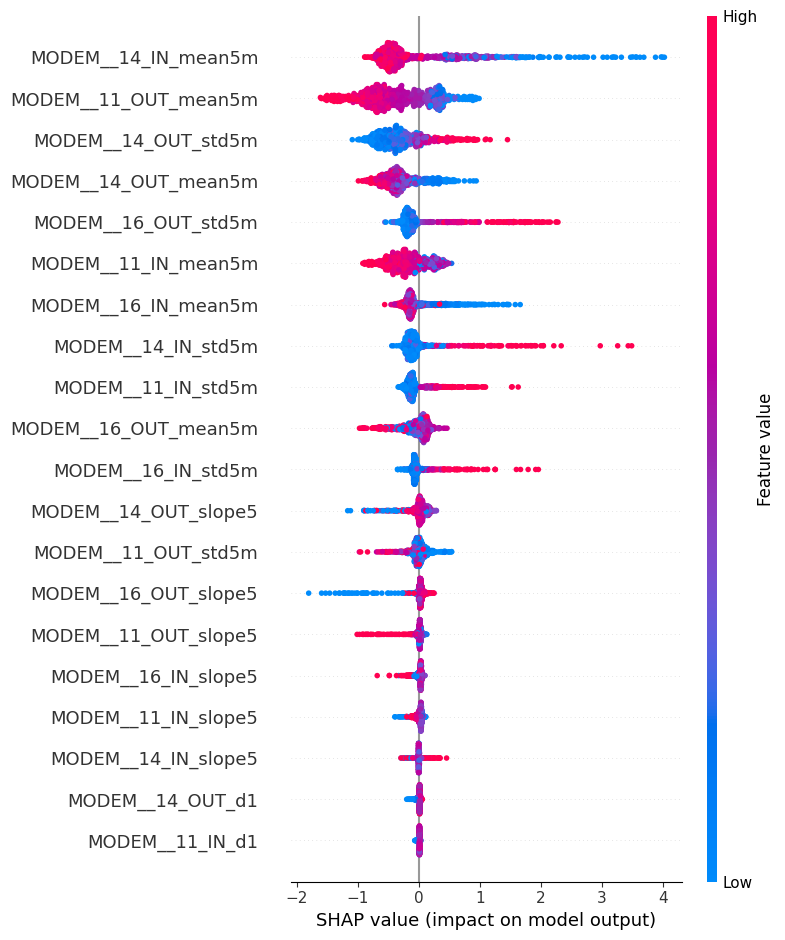

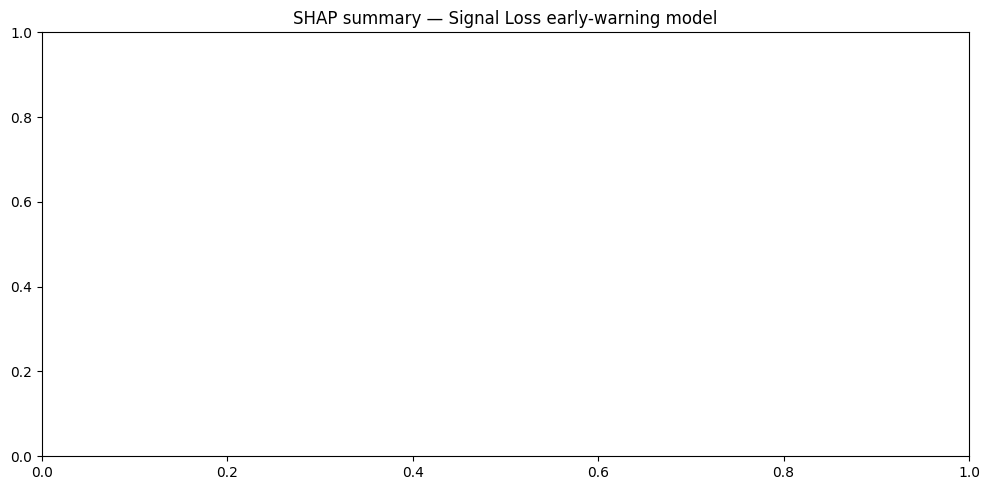

In [24]:
# ============================================================
# Step 12 — Explainability with SHAP (global + local)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = False


# Use TRAIN as background; TEST for explanations
X_train_shap = X_train.copy()
X_test_shap  = X_test.copy()
feature_names = X_train_shap.columns.tolist()

explainer = shap.TreeExplainer(clf)

# Sample up to 1000 TEST points for SHAP
n_sample = min(1000, len(X_test_shap))
rng = np.random.RandomState(42)
sample_idx = rng.choice(len(X_test_shap), size=n_sample, replace=False)
X_sample = X_test_shap.iloc[sample_idx]

shap_values_sample = explainer.shap_values(X_sample)

print("[Signal Loss] Global SHAP summary (TEST sample):")
shap.summary_plot(
    shap_values_sample,
    X_sample,
    feature_names=feature_names,
    show=True
)
plt.title("SHAP summary — Signal Loss early-warning model")
plt.tight_layout()
plt.show()



=== Signal Loss anomaly candidate 1 ===
Time: 2021-11-26 05:50:10+00:00 | P(signal loss): 1.0


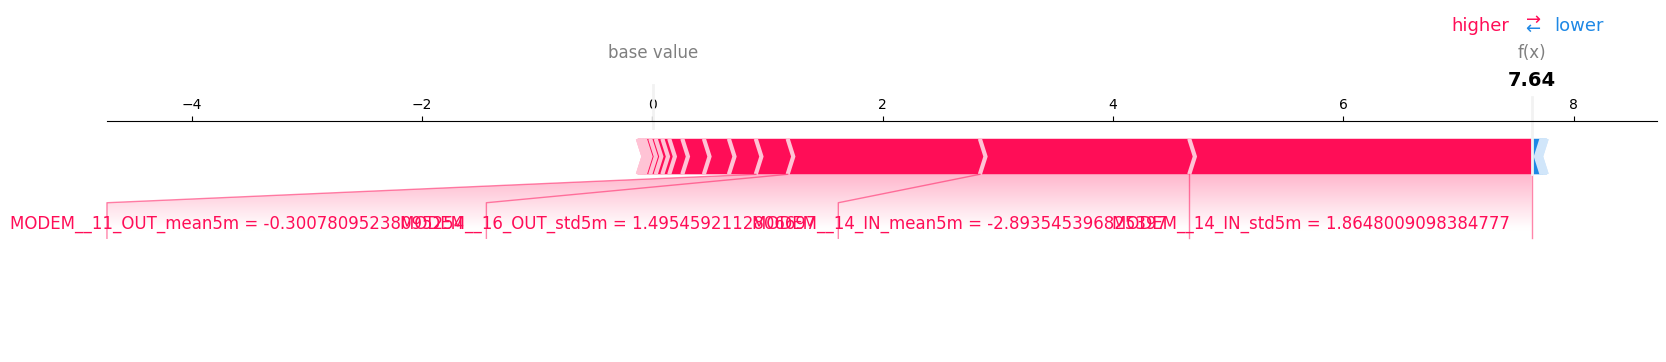


=== Signal Loss anomaly candidate 2 ===
Time: 2021-11-26 05:50:00+00:00 | P(signal loss): 0.999


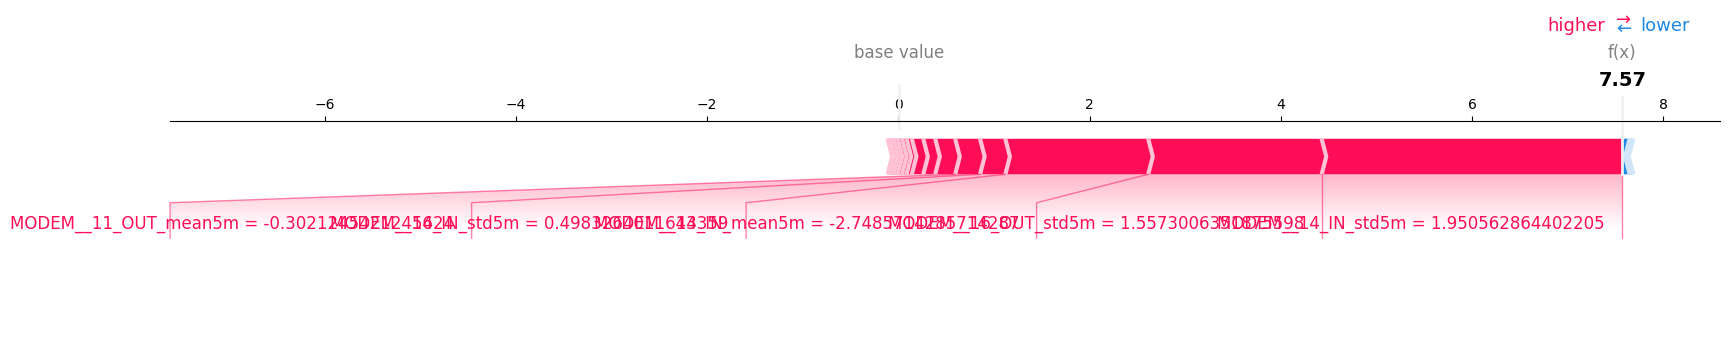


=== Signal Loss anomaly candidate 3 ===
Time: 2021-11-24 05:48:30+00:00 | P(signal loss): 0.999


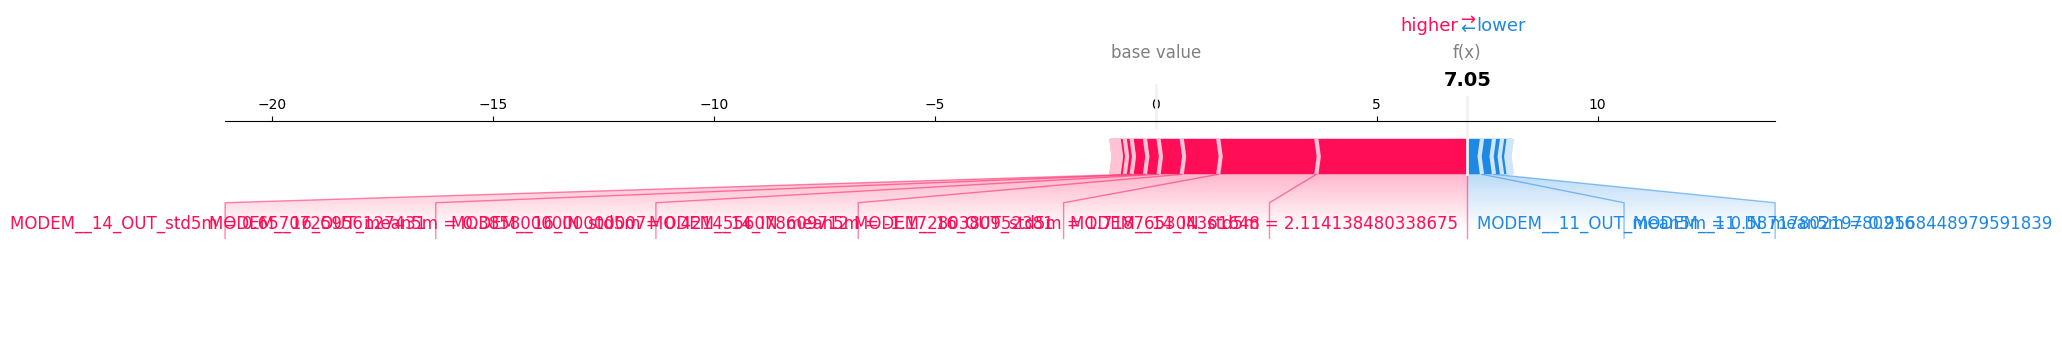


=== Signal Loss anomaly candidate 4 ===
Time: 2021-11-30 11:48:00+00:00 | P(signal loss): 0.999


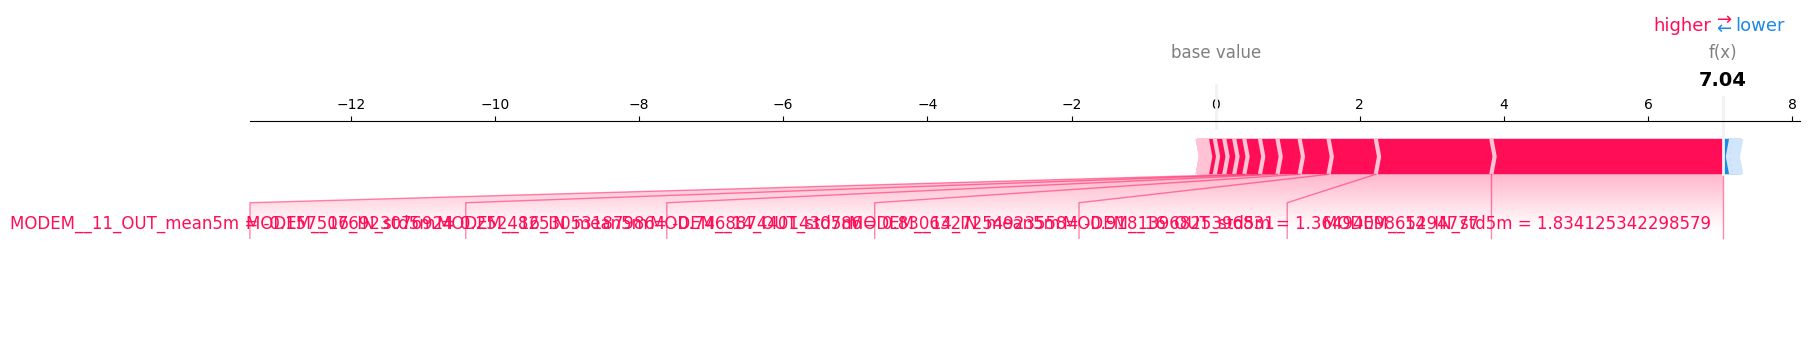


=== Signal Loss anomaly candidate 5 ===
Time: 2021-11-27 05:48:30+00:00 | P(signal loss): 0.999


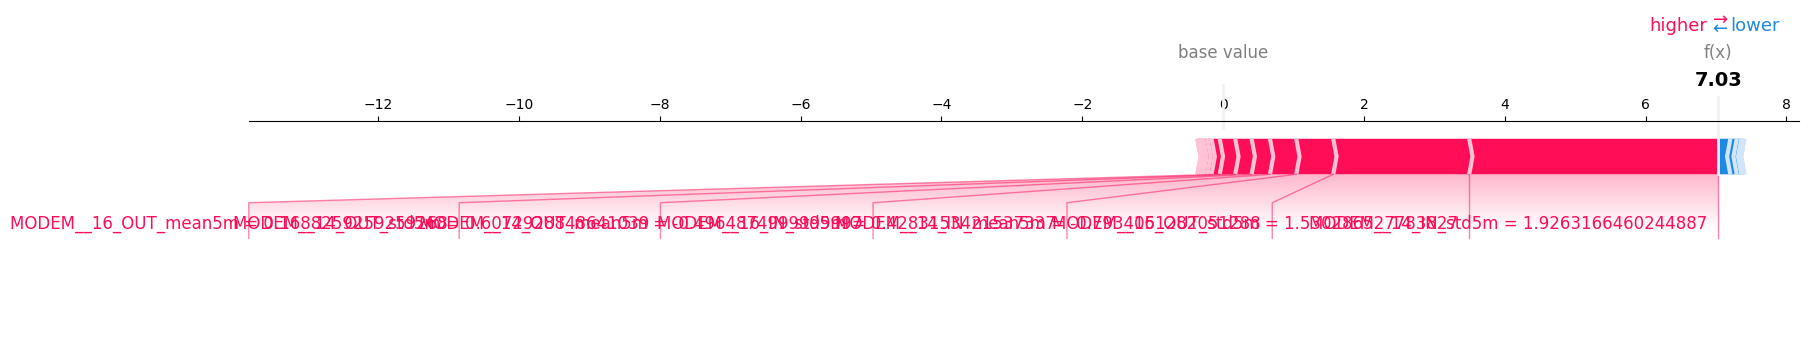

In [25]:
# ============================================================
# Step 12B - Local SHAP explanations for top 5 highest P(signal_loss) in TEST
# ============================================================

proba_test_arr = np.asarray(proba_test)
test_index_arr = np.asarray(X_test.index)

top_k = 5
top_idx = np.argsort(proba_test_arr)[-top_k:][::-1]

for rank, i in enumerate(top_idx, start=1):
    t = test_index_arr[i]
    p = proba_test_arr[i]
    print(f"\n=== Signal Loss anomaly candidate {rank} ===")
    print("Time:", t, "| P(signal loss):", round(p, 3))

    x_instance = X_test_shap.iloc[[i]]
    shap_vals_instance = explainer.shap_values(x_instance)

    shap.force_plot(
        explainer.expected_value,
        shap_vals_instance[0],
        x_instance,
        matplotlib=True,
        show=True
    )


Using first ground-truth event: 2021-11-22 02:00:30+00:00 -> 2021-11-22 02:02:30+00:00
Event window for SHAP heatmap: 2021-11-22 01:50:30+00:00 -> 2021-11-22 02:12:30+00:00
Saved event heatmap to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_signal_loss/signal_loss_event_heatmap.png


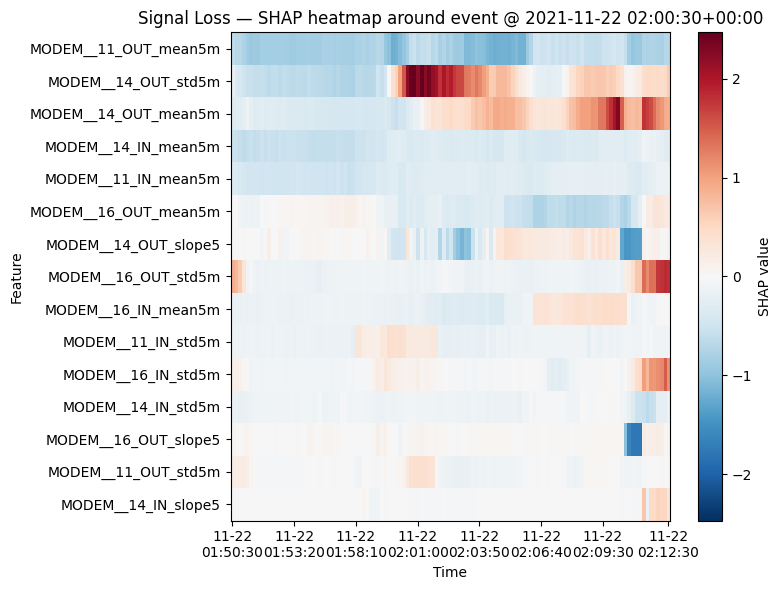

Saved continuous heatmap to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_signal_loss/signal_loss_continuous_heatmap.png


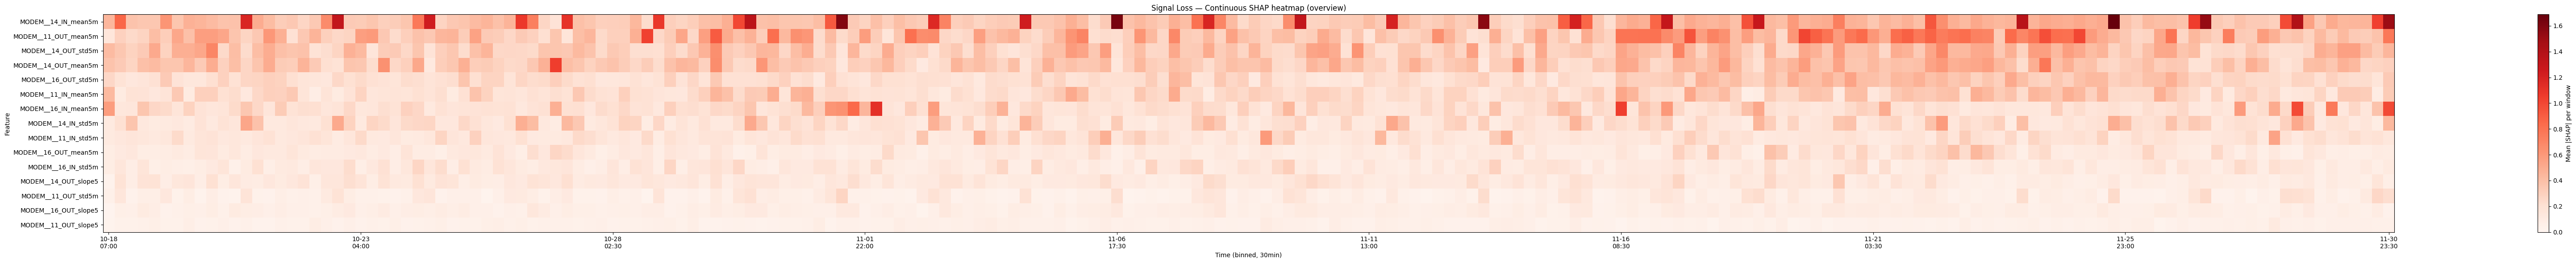

=== SHAP heatmaps for Signal Loss done. ===


In [26]:
# ============================================================
# Step 12c - SHAP HEATMAPS
# ============================================================


# === SIGNAL LOSS — SHAP HEATMAPS (EVENT + CONTINUOUS) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = False

# Make sure output directory exists
OUT_SL = os.path.join(DATA_DIR, "artifacts_signal_loss")
os.makedirs(OUT_SL, exist_ok=True)

# --------------------------------------------------------
# Helper 1: Compute SHAP values for a given time window
# --------------------------------------------------------
def compute_shap_window(explainer,
                        X_full: pd.DataFrame,
                        t_start: pd.Timestamp,
                        t_end: pd.Timestamp,
                        max_points: int = 300):
    """
    Compute SHAP values for a time window [t_start, t_end] on X_full.

    Parameters
    ----------
    explainer : shap.Explainer or TreeExplainer
        Fitted SHAP explainer for the model.
    X_full : pd.DataFrame
        Feature matrix with a DatetimeIndex (full series).
    t_start, t_end : pd.Timestamp
        Start and end of the window.
    max_points : int
        If too many points in the window, we downsample (uniform).

    Returns
    -------
    X_win : pd.DataFrame
    shap_vals : np.ndarray
        SHAP values of shape (n_samples, n_features).
    """
    # 1) Slice by time
    X_win = X_full.loc[t_start:t_end]
    if X_win.empty:
        raise ValueError("No samples in the requested time window.")

    # 2) Downsample if necessary
    if len(X_win) > max_points:
        idx = np.linspace(0, len(X_win) - 1, max_points).astype(int)
        X_win = X_win.iloc[idx]

    # 3) Compute SHAP values
    shap_vals = explainer.shap_values(X_win)

    # For tree models: (n_samples, n_features)
    # For multi-class: list -> pick first class
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[0]

    return X_win, np.array(shap_vals)

# --------------------------------------------------------
# Helper 2: Per-event SHAP heatmap
# --------------------------------------------------------
def plot_shap_event_heatmap(X_win: pd.DataFrame,
                            shap_vals: np.ndarray,
                            top_n_features: int = 15,
                            title: str = None,
                            save_path: str = None):
    """
    Plot a SHAP 'saliency-style' heatmap over time for a given event window.

    Rows = features (top_n by mean |SHAP|)
    Columns = time steps in the window
    Color = SHAP value (red pushes towards anomaly, blue towards normal).
    """
    assert shap_vals.shape[0] == len(X_win)
    feature_names = X_win.columns

    # 1) Rank features by mean |SHAP|
    mean_abs = np.mean(np.abs(shap_vals), axis=0)
    order = np.argsort(mean_abs)[::-1]  # descending importance

    if top_n_features is not None:
        order = order[:top_n_features]

    shap_sel = shap_vals[:, order]
    feat_sel = feature_names[order]

    # 2) Matrix: features x time
    mat = shap_sel.T  # shape: (n_features, n_samples)
    times = X_win.index

    plt.figure(figsize=(max(8, len(times) / 20), max(4, top_n_features * 0.4)))
    vmax = np.max(np.abs(mat))
    im = plt.imshow(
        mat,
        aspect="auto",
        cmap="RdBu_r",
        interpolation="nearest",
        vmin=-vmax,
        vmax=vmax,
    )
    plt.colorbar(im, label="SHAP value")

    # y-axis: features
    plt.yticks(ticks=np.arange(len(feat_sel)), labels=feat_sel)

    # x-axis: time labels (sparse)
    n_ticks = min(8, len(times))
    tick_idx = np.linspace(0, len(times) - 1, n_ticks).astype(int)
    tick_labels = [times[i].strftime("%m-%d\n%H:%M:%S") for i in tick_idx]
    plt.xticks(ticks=tick_idx, labels=tick_labels)

    plt.xlabel("Time")
    plt.ylabel("Feature")
    plt.title(title or "Signal Loss — SHAP event heatmap")

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print("Saved event heatmap to:", save_path)
    plt.show()

# --------------------------------------------------------
# Helper 3: Continuous SHAP heatmap (overview)
# --------------------------------------------------------
def plot_shap_continuous_heatmap(explainer,
                                 X_full: pd.DataFrame,
                                 window_size: str = "30min",
                                 max_windows: int = 200,
                                 top_n_features: int = 15,
                                 title: str = None,
                                 save_path: str = None):
    """
    Continuous SHAP heatmap: bin time into windows, compute average |SHAP| per feature per window.

    - Each column = time window (e.g. 30 minutes)
    - Each row    = feature
    - Color       = average |SHAP| in that window.
    """
    # 1) Group by time windows
    X_grouped = []
    time_bins = []

    for t_bin, X_bin in X_full.groupby(pd.Grouper(freq=window_size)):
        if X_bin.empty:
            continue
        X_grouped.append(X_bin)
        time_bins.append(t_bin)

    if not X_grouped:
        raise ValueError("No data for SHAP continuous heatmap.")

    # Downsample number of windows if needed
    if len(X_grouped) > max_windows:
        idx = np.linspace(0, len(X_grouped) - 1, max_windows).astype(int)
        X_grouped = [X_grouped[i] for i in idx]
        time_bins = [time_bins[i] for i in idx]

    feature_names = X_full.columns
    mat_list = []

    # 2) SHAP -> mean |SHAP| per feature per window
    for X_bin in X_grouped:
        X_bin_small = X_bin
        if len(X_bin_small) > 300:
            idx = np.linspace(0, len(X_bin_small) - 1, 300).astype(int)
            X_bin_small = X_bin_small.iloc[idx]

        shap_vals_bin = explainer.shap_values(X_bin_small)
        if isinstance(shap_vals_bin, list):
            shap_vals_bin = shap_vals_bin[0]

        mean_abs_bin = np.mean(np.abs(shap_vals_bin), axis=0)
        mat_list.append(mean_abs_bin)

    mat = np.vstack(mat_list).T  # shape: (n_features, n_windows)

    # 3) Select top_n features globally
    global_mean_abs = np.mean(mat, axis=1)
    order = np.argsort(global_mean_abs)[::-1]
    if top_n_features is not None:
        order = order[:top_n_features]

    mat_sel = mat[order, :]
    feat_sel = feature_names[order]

    # 4) Plot heatmap
    plt.figure(figsize=(max(8, len(time_bins) / 3), max(4, top_n_features * 0.4)))
    im = plt.imshow(
        mat_sel,
        aspect="auto",
        cmap="Reds",
        interpolation="nearest",
        vmin=0,
        vmax=np.max(mat_sel),
    )
    plt.colorbar(im, label="Mean |SHAP| per window")

    plt.yticks(ticks=np.arange(len(feat_sel)), labels=feat_sel)

    n_ticks = min(10, len(time_bins))
    tick_idx = np.linspace(0, len(time_bins) - 1, n_ticks).astype(int)
    tick_labels = [time_bins[i].strftime("%m-%d\n%H:%M") for i in tick_idx]
    plt.xticks(ticks=tick_idx, labels=tick_labels)

    plt.xlabel(f"Time (binned, {window_size})")
    plt.ylabel("Feature")
    plt.title(title or "Signal Loss — Continuous SHAP heatmap")

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print("Saved continuous heatmap to:", save_path)
    plt.show()

# --------------------------------------------------------
# PART A — Per-event SHAP heatmap for Signal Loss
# --------------------------------------------------------

# We try to use an existing ground-truth event if available (gt_events from Step11).
# If not available, we fall back to the highest-risk timestamp in X_test.

if "gt_events" in globals() and isinstance(gt_events, list) and len(gt_events) > 0:
    event_start, event_end = gt_events[0]
    print("Using first ground-truth event:", event_start, "->", event_end)
else:
    print("gt_events not found or empty. Falling back to top-risk test timestamp.")
    proba_test_arr = np.asarray(proba_test)
    X_test_index = np.asarray(X_test.index)
    i_top = int(np.argmax(proba_test_arr))
    event_start = pd.to_datetime(X_test_index[i_top])
    event_end = event_start + pd.Timedelta(minutes=5)
    print("Using window around:", event_start, "->", event_end)

# Add padding around the event window (for context)
pad = pd.Timedelta(minutes=10)
t_start = event_start - pad
t_end = event_end + pad

print("Event window for SHAP heatmap:", t_start, "->", t_end)

# Compute SHAP in this window and plot
X_win_sl, shap_vals_sl = compute_shap_window(
    explainer=explainer,
    X_full=X,          # full feature matrix used for training/testing
    t_start=t_start,
    t_end=t_end,
    max_points=300
)

plot_shap_event_heatmap(
    X_win_sl,
    shap_vals_sl,
    top_n_features=15,
    title=f"Signal Loss — SHAP heatmap around event @ {event_start}",
    save_path=os.path.join(OUT_SL, "signal_loss_event_heatmap.png")
)

# --------------------------------------------------------
# PART B — Continuous SHAP heatmap (overview)
# --------------------------------------------------------
plot_shap_continuous_heatmap(
    explainer=explainer,
    X_full=X,   # you can also restrict to X_test if you prefer
    window_size="30min",
    max_windows=200,
    top_n_features=15,
    title="Signal Loss — Continuous SHAP heatmap (overview)",
    save_path=os.path.join(OUT_SL, "signal_loss_continuous_heatmap.png")
)

print("=== SHAP heatmaps for Signal Loss done. ===")


In [27]:
# ============================================================
# Step 13 — Save artifacts (models, scores, config) and final summary
# ============================================================

OUT = os.path.join(DATA_DIR, "artifacts_signal_loss")
os.makedirs(OUT, exist_ok=True)

# Per-timestep raw test scores
pd.DataFrame({
    "timestamp": X_test.index,
    "proba_raw": proba_test,
    "y_true": y_test_aligned.values
}).to_csv(os.path.join(OUT, "test_scores_raw.csv"), index=False)

# Per-timestep eventized scores
pred_events_ts = pd.Series(0, index=test_index)
for s, e in events:
    pred_events_ts.loc[s:e] = 1

pd.DataFrame({
    "timestamp": test_index,
    "proba_smoothed": proba_sm.values,
    "pred_event": pred_events_ts.values,
    "y_true": y_test_aligned.values
}).to_csv(os.path.join(OUT, "test_eventized_scores.csv"), index=False)

# Save model
clf.save_model(os.path.join(OUT, "model_signal_loss.json"))

# Save configuration and metrics
CONFIG = {
    "threshold_val": float(thr_star),
    "ema_span": int(EMA_SPAN),
    "on_thr": float(ON_THR),
    "off_thr": float(OFF_THR),
    "k": int(K),
    "m": int(M),
    "min_duration_s": int(MIN_DURATION_S),
    "refractory_s": int(REFRACTORY_S),
    "metrics": {
        "val_ap": float(ap_val),
        "test_pr_auc": float(average_precision_score(y_test, proba_test)),
        "test_roc_auc": float(roc_auc_score(y_test, proba_test)),
        "raw_far_per_hour": float(far_per_hour_raw),
        "raw_delay_s": float(delay_s_raw if delay_s_raw is not None else np.nan),
        "event_far_per_hour": float(fa_per_hour_ev),
        "event_delay_s": float(med_delay_s_ev),
        "event_precision": float(ev_prec),
        "event_recall": float(ev_rec),
    }
}

with open(os.path.join(OUT, "config.json"), "w") as f:
    json.dump(CONFIG, f, indent=2)

print("Artifacts saved to:", OUT)


Artifacts saved to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_signal_loss


In [28]:
# ============================================================
# Step 14 — Console summary
# ============================================================

print("\n--- SIGNAL LOSS — FINAL SUMMARY ---")
print("VAL AP:", round(CONFIG["metrics"]["val_ap"], 3))
print("TEST PR-AUC:", round(CONFIG["metrics"]["test_pr_auc"], 3))
print("TEST ROC-AUC:", round(CONFIG["metrics"]["test_roc_auc"], 3))
print("Raw FAR (alerts/hour):", round(CONFIG["metrics"]["raw_far_per_hour"], 2),
      "| Raw delay (s):", CONFIG["metrics"]["raw_delay_s"])
print("Eventized FAR (alerts/hour):", round(CONFIG["metrics"]["event_far_per_hour"], 3),
      "| Event delay (s):", round(CONFIG["metrics"]["event_delay_s"], 1))
print("Event Precision:", round(CONFIG["metrics"]["event_precision"], 3),
      "| Event Recall:", round(CONFIG["metrics"]["event_recall"], 3))
print("-----------------------------------")



--- SIGNAL LOSS — FINAL SUMMARY ---
VAL AP: 0.716
TEST PR-AUC: 0.72
TEST ROC-AUC: 0.827
Raw FAR (alerts/hour): 48.88 | Raw delay (s): 0.0
Eventized FAR (alerts/hour): 0.537 | Event delay (s): 4490.0
Event Precision: 0.93 | Event Recall: 0.127
-----------------------------------
